In [ ]:
# 전이 학습
# 다른 모델의 학습한 가중치를 가지고, 추가로 내 모델에 적용할 수 있다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
np.random.seed(3)
tf.random.set_seed(3)

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                             horizontal_flip=True,
                                                             width_shift_range = 0.1,
                                                             height_shift_range=0.1,
                                                             rotation_range=5,
                                                             shear_range = 0.7,
                                                             zoom_range=[0.9, 2.2],
                                                             vertical_flip=True,
                                                             fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    directory = 'train/', target_size = (150, 150),
    save_to_dir='gen_train/', 
    batch_size=5, class_mode = 'binary')


Found 157 images belonging to 3 classes.


In [4]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    directory = 'test/', target_size = (150, 150),
    save_to_dir='gen_test/', 
    batch_size=5, class_mode = 'binary')

Found 120 images belonging to 3 classes.


In [10]:
transfer_model = keras.applications.VGG16(weights = 'imagenet', 
                                          include_top=False,
                                          input_shape=(150, 150, 3)) #이미지는 150, 150 size의 color
# 학습된 weight를 변경하지 않는다. trainable = False 설정을 해준다.
transfer_model.trainable = False
transfer_model.summary()

# 뒤에 것은 우리가 만든다고 해서 finetune이라고 한다.
finetune_model = keras.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(keras.layers.Flatten())
finetune_model.add(keras.layers.Dense(64, activation='relu'))
finetune_model.add(keras.layers.Dense(1, activation = 'sigmoid')) # Dense(2 이면, softmax로 할 것)
finetune_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [11]:
finetune_model.compile(loss = 'binary_crossentropy',
                       optimizer = keras.optimizers.Adam(learning_rate=0.002),
                       metrics=['accuracy'])

In [12]:
# steps_per_epoch = len(x_train) 160 / batch_size 5
# validation_steps = len(x_test) 120 / batch_size 5 
history = finetune_model.fit_generator(
    train_generator, 
    steps_per_epoch = 10,
    epochs = 10,
    validation_data=test_generator,
    validation_steps = 4)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


10/10 [==============================] - 19s 2s/step - loss: -12.7678 - accuracy: 0.4400 - val_loss: -35.1455 - val_accuracy: 0.4000
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: -62.0542 - accuracy: 0.4043 - val_loss: -76.6691 - val_accuracy: 0.4500
Epoch 3/10
10/10 [==============================] - 16s 2s/step - loss: -106.4535 - accuracy: 0.4600 - val_loss: -174.8551 - val_accuracy: 0.3000
Epoch 4/10
10/10 [==============================] - 16s 2s/step - loss: -167.6193 - accuracy: 0.4894 - val_loss: -230.3498 - val_accuracy: 0.4000
Epoch 5/10
10/10 [==============================] - 16s 2s/step - loss: -293.4502 - accuracy: 0.4000 - val_loss: -223.6511 - val_accuracy: 0.6000
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: -444.8304 - accuracy: 0.3600 - val_loss: -429.7215 - val_accuracy: 0.4500
Epoch 7/10
10/10 [==============================] - 17s 2s/step - loss: -489.1242 - accuracy: 0.4800 - val_loss: -471.6799 - val_accuracy: 

In [14]:
print(history.history.keys())
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
y_acc = history.history['accuracy']
y_loss = history.history['loss']

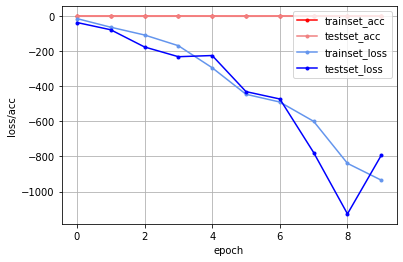

In [17]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_acc, marker = '.', c='red', label='trainset_acc')
plt.plot(x_len, val_acc, marker = '.', c='lightcoral', label='testset_acc')
plt.plot(x_len, y_loss, marker = '.', c='cornflowerblue', label='trainset_loss')
plt.plot(x_len, val_loss, marker = '.', c='blue', label='testset_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()